In [1]:
import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from numpy import log, sqrt, cos, pi
import numpy as np

import math
import pylab
#from cratools import *

In [6]:
def plot_map(skymap, title, label='', proj='C', dMin=None, dMax=None, filename=None, watermark='', half_map=False):
    #Colorway
    colormap = pylab.get_cmap("rainbow")  
    notext=False
    
    if proj=='C':
        rotation = (-180,0,0)
    else:
        rotation = (0,0,0)
    
    hp.mollview(skymap, 
            fig=1,
            title=title, 
            rot=rotation,coord=[proj],
            unit=label,
            notext=notext, cmap = colormap,min=dMin,max=dMax)

    fig = pylab.figure(1)
    for ax in fig.get_axes():
            if proj=='C0':
                ax.annotate("0$^\circ$", xy=(1.8, 0.625), size="x-large")
                ax.annotate("360$^\circ$",xy=(-1.95, 0.625), size="x-large")
            elif proj=='C':
                ax.annotate("0$^\circ$", xy=(1.8, 0.625), size="x-large")
                ax.annotate("360$^\circ$",xy=(-1.95, 0.625), size="x-large")
                if half_map:
                    ax.annotate("0$^\circ$", xy=(1.8, -0.625), size="x-large")
                    ax.annotate("360$^\circ$",xy=(-1.99, -0.625), size="x-large")
    
    hp.graticule()
    hp.projtext(95*degree+(rotation[0]-180)*degree, 280*degree-rotation[1]*degree,
                    watermark,
                    #coord=coords,
                    color="grey",
                    alpha=0.5,
                    rotation=0,
                    fontdict={"family":"sans-serif", "weight":"bold", "size":42})
    
    if half_map:
        #ax = plt.pyplot.gca():
        plt.ylim([-1,0])
        
    if filename:
        fig.savefig(filename, transparent=True, dpi=100)
    
    plt.show()
    
def maskMap(map, decmin, decmax):
    degree = pi / 180.
    npix  = len(map) #not map.size?
    nside = hp.npix2nside(npix)
    theta, phi = hp.pix2ang(nside, range(npix))

    thetaMin = (90 - decmin) * degree
    thetaMax = (90 - decmax) * degree
    thetaCut = (theta <= thetaMin) * (theta >= thetaMax)

    new_map = np.copy(map) #not copy.deepcopy(map)?
    new_map[np.logical_not(thetaCut)] = hp.UNSEEN 

    return new_map

def smoothMap(m, wtsqr=False, norm=False, smooth_rad=0):

    if wtsqr==True:
        return None

    npix  = len(m)
    nside = hp.npix2nside(npix)
    #smooth_rad = opts['smooth'] * pi/180.
    smooth_map = np.zeros(npix)

    vec = np.transpose(hp.pix2vec(nside, np.arange(npix)))
    for i in range(npix):
        neighbors = hp.query_disc(nside, vec[i], smooth_rad)
        smooth_map[i] += m[neighbors].sum()
        if norm:
            smooth_map[i] /= (len(neighbors) + 1)

    return smooth_map

def TopHatSmooth(nside, origMap, radius, average=False):
    pixelList = []
    dsum = 0.0
    newmap = np.zeros(len(origMap))

    # Loop over all pixels
    for ipix in range(0, len(origMap)):
        # Ignore masked pixels
        if origMap[ipix] == hp.UNSEEN:
            newmap[ipix] = hp.UNSEEN
        else:
            theta,phi = hp.pix2ang(nside, ipix)
            center = hp.dir2vec(theta,phi)

            # Grab pixels with given angular radius of ith pixel
            pixelList = hp.query_disc(nside, center, radius)

            #Sum up pixels in the angular cap; set value of ith pixel to this sum
            dsum = 0.
            nsum = 0.
            for jpix in pixelList:
                if origMap[jpix] != hp.UNSEEN:
                   dsum += origMap[jpix]
                   nsum += 1.0

            if average and nsum>0:
                newmap[ipix] = dsum/nsum # set to average
            else:
                newmap[ipix] = dsum
    return newmap

In [11]:
#ROOT DIRECTORY
root = "sidereal_fits/"

#This is where you pick what range of data you want to see. Note that this is in declination.
decMin=-90.0
decMax=-35.0

#this is used to decide how much smoothing is done
smoothAngle=20

nside = 64 #change to get from map as opposed to hard coding
degree = pi / 180.

radius_smooth = smoothAngle * degree


print(str(hp.nside2resol(nside, arcmin=True) / 60))
print(str(hp.nside2pixarea(nside)))

output_dir = "output/"

0.9161297098179749
0.00025566346464760684


In [9]:
# TIER 1 

# Load fits files

data, bg, combined_llh_iter20 = hp.read_map(root+"combined_t1_iteration20.fits.gz", [0, 1, 2])
variance_llh_iter20, sig, mean = hp.read_map(root+"significance_t1_iteration20.fits.gz", [0, 1, 2])

Title = "Energy Tier 1: 310 TeV 2011-14"

#Relative Intensity
"""
#FRANKS METHOD
data_smooth = smoothMap(data, smooth_rad=radius_smooth)
bg_smooth = smoothMap(bg, smooth_rad=radius_smooth)
m = (data_smooth - bg_smooth) / bg_smooth
m[np.isnan(m)] = 0
smoothed_map = maskMap(m, decMin, decMax)

plot_map(smoothed_map, Title, label="Rel. Int. ", half_map=True) #, dMin = -.0005, dMax = .0005)

""" 

#Juan Carlos' Method 

ri = data/bg - 1
ri_mask = maskMap(ri, decMin, decMax)
ri_smooth = TopHatSmooth(nside, ri_mask, radius=radius_smooth, average=True)
plot_map(ri_smooth, Title, half_map=True) #, dMin=-.006, dMax=.006)

#"""

# Significance
mask_sig = maskMap(sig, decMin, decMax)
plot_map(mask_sig, Title, label="Significance [σ]", half_map=True) #, dMin= -3, dMax = 3)

"""
#Plot with specificed range(s) and save
#RI
plot_map(smoothed_map, Title, label='Rel. Int. ', half_map = True, dMin = -.0007, dMax = .0007,
         filename=output_dir+"et1_anti_ri.png")
#Signed sig
plot_map(mask_sig, Title, 
         label='Significance [$\sigma$]', half_map=True, dMin=-3, dMax=3,
         filename=output_dir+"et1_anti_sig.png")
#"""

FileNotFoundError: [Errno 2] No such file or directory: '/sidereal_fits/combined_t1_iteration20.fits.gz'

NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/cvmfs/icecube.opensciencegrid.org/py3-v4.1.1/Ubuntu_20.04_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


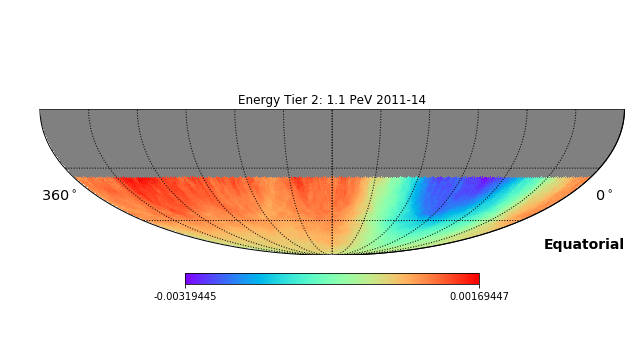

'\n\n# Significance\nmask_sig = maskMap(sig, decMin, decMax)\nplot_map(mask_sig, Title, label="Significance [σ]", half_map=True) #, dMin= -3, dMax = 3)\n\n\n#Plot with specificed range(s) and save\n#RI\nplot_map(smoothed_map, Title, label=\'Rel. Int. \', half_map = True, dMin = -.0006, dMax = .0006,\n         filename=output_dir+"et2_solar_ri.png")\n#Signed sig\nplot_map(mask_sig, Title, \n         label=\'Significance [$\\sigma$]\', half_map=True, dMin=-3, dMax=3,\n         filename=output_dir+"et2_solar_sig.png")\n'

In [17]:
# TIER 2

# Load fits files

data, bg, combined_llh_iter20 = hp.read_map(root+"combined_t2_iteration20.fits.gz", [0, 1, 2])
variance_llh_iter20, sig, mean = hp.read_map(root+"significance_t2_iteration20.fits.gz", [0, 1, 2])

Title = "Energy Tier 2: 1.1 PeV 2011-14"

#Relative Intensity
"""
#FRANKS METHOD
data_smooth = smoothMap(data, smooth_rad=radius_smooth)
bg_smooth = smoothMap(bg, smooth_rad=radius_smooth)
m = (data_smooth - bg_smooth) / bg_smooth
m[np.isnan(m)] = 0
smoothed_map = maskMap(m, decMin, decMax)

plot_map(smoothed_map, Title, label="Rel. Int. ", half_map=True) #, dMin = -.0006, dMax = .0006)

""" 

#Juan Carlos' Method 

ri = data/bg - 1
ri_mask = maskMap(ri, decMin, decMax)
ri_smooth = TopHatSmooth(nside, ri_mask, radius=radius_smooth, average=True)
plot_map(ri_smooth, Title, half_map=True) #, dMin=-.006, dMax=.006)

"""

# Significance
mask_sig = maskMap(sig, decMin, decMax)
plot_map(mask_sig, Title, label="Significance [σ]", half_map=True) #, dMin= -3, dMax = 3)


#Plot with specificed range(s) and save
#RI
plot_map(smoothed_map, Title, label='Rel. Int. ', half_map = True, dMin = -.0006, dMax = .0006,
         filename=output_dir+"et2_solar_ri.png")
#Signed sig
plot_map(mask_sig, Title, 
         label='Significance [$\sigma$]', half_map=True, dMin=-3, dMax=3,
         filename=output_dir+"et2_solar_sig.png")
"""

NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/cvmfs/icecube.opensciencegrid.org/py3-v4.1.1/Ubuntu_20.04_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


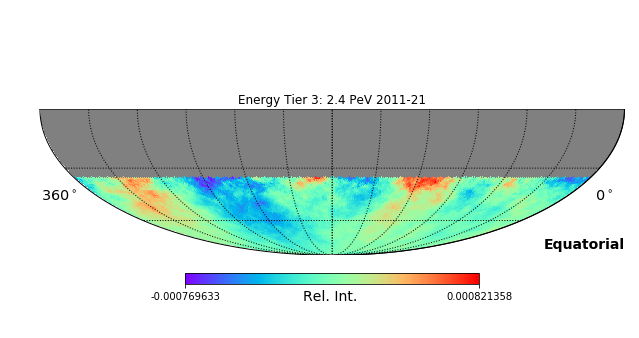

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


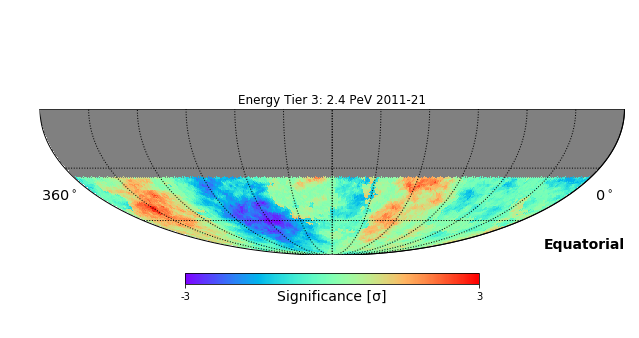

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


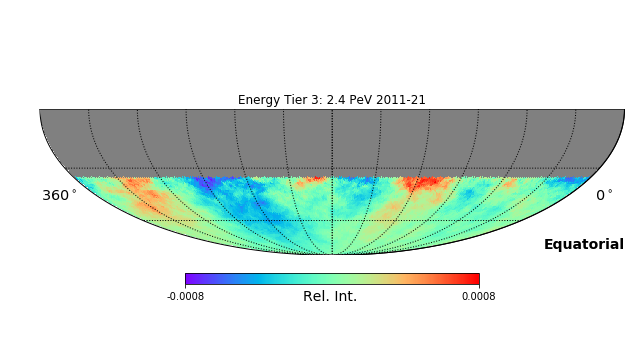

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


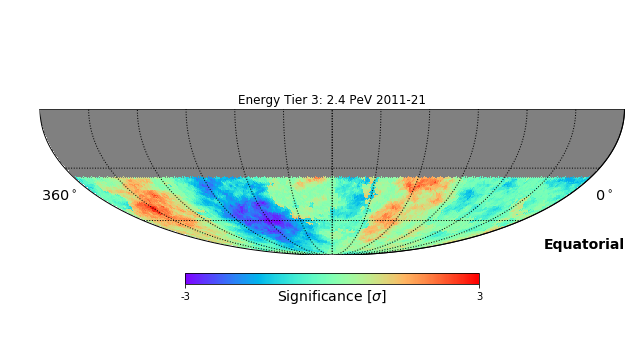

In [6]:
# TIER 3

# Load fits files

data, bg, combined_llh_iter20 = hp.read_map(root+"combined_t3_iteration08.fits.gz", [0, 1, 2])
variance_llh_iter20, sig, mean = hp.read_map(root+"significance_t3_iteration08.fits.gz", [0, 1, 2])

Title = "Energy Tier 3: 2.4 PeV 2011-21"

#Relative Intensity

#FRANKS METHOD
data_smooth = smoothMap(data, smooth_rad=radius_smooth)
bg_smooth = smoothMap(bg, smooth_rad=radius_smooth)
m = (data_smooth - bg_smooth) / bg_smooth
m[np.isnan(m)] = 0
smoothed_map = maskMap(m, decMin, decMax)

plot_map(smoothed_map, Title, label="Rel. Int. ", half_map=True) #, dMin = -.006, dMax = .006)

""" 

#Juan Carlos' Method 

ri = data/bg - 1
ri_mask = maskMap(ri, decMin, decMax)
ri_smooth = TopHatSmooth(nside, ri_mask, radius=radius_smooth, average=True)
plot_map(ri_smooth, Title, half_map=True, dMin=-.006, dMax=.006)

"""

# Significance
mask_sig = maskMap(sig, decMin, decMax)
plot_map(mask_sig, Title, label="Significance [σ]", half_map=True, dMin= -3, dMax = 3)

#"""
#Plot with specificed range(s) and save
#RI
plot_map(smoothed_map, Title, label='Rel. Int. ', half_map = True, dMin = -.0008, dMax = .0008,
         filename=output_dir+"et3_solar_ri.png")
#Signed sig
plot_map(mask_sig, Title, 
         label='Significance [$\sigma$]', half_map=True, dMin=-3, dMax=3,
         filename=output_dir+"et3_solar_sig.png")
#"""

NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 64
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/cvmfs/icecube.opensciencegrid.org/py3-v4.1.1/Ubuntu_20.04_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


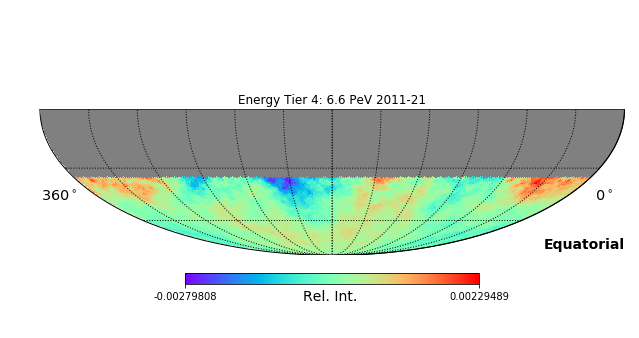

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


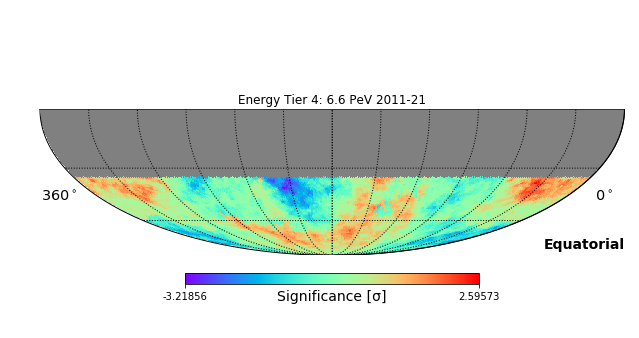

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


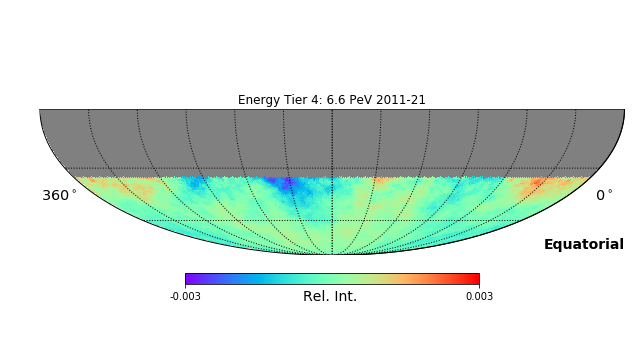

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


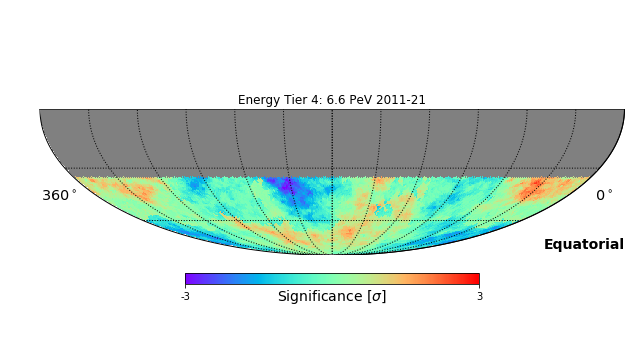

In [10]:
# TIER 4

# Load fits files

data, bg, combined_llh_iter20 = hp.read_map(root+"combined_t4_iteration20.fits.gz", [0, 1, 2])
variance_llh_iter20, sig, mean = hp.read_map(root+"significance_t4_iteration20.fits.gz", [0, 1, 2])

Title = "Energy Tier 4: 6.6 PeV 2011-21"

#Relative Intensity

#FRANKS METHOD
data_smooth = smoothMap(data, smooth_rad=radius_smooth)
bg_smooth = smoothMap(bg, smooth_rad=radius_smooth)
m = (data_smooth - bg_smooth) / bg_smooth
m[np.isnan(m)] = 0
smoothed_map = maskMap(m, decMin, decMax)

plot_map(smoothed_map, Title, label="Rel. Int. ", half_map=True)#, dMin = -.006, dMax = .006)

""" 

#Juan Carlos' Method 

ri = data/bg - 1
ri_mask = maskMap(ri, decMin, decMax)
ri_smooth = TopHatSmooth(nside, ri_mask, radius=radius_smooth, average=True)
plot_map(ri_smooth, Title, half_map=True, dMin=-.006, dMax=.006)

"""

# Significance
mask_sig = maskMap(sig, decMin, decMax)
plot_map(mask_sig, Title, label="Significance [σ]", half_map=True) #, dMin= -3, dMax = 3)

#"""
#Plot with specificed range(s) and save
#RI
plot_map(smoothed_map, Title, label='Rel. Int. ', half_map = True, dMin = -.003, dMax = .003,
         filename=output_dir+"et4_solar_ri.png")
#Signed sig
plot_map(mask_sig, Title, 
         label='Significance [$\sigma$]', half_map=True, dMin=-3, dMax=3,
         filename=output_dir+"et4_solar_sig.png")
#"""

In [ ]:
# Legacy code

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


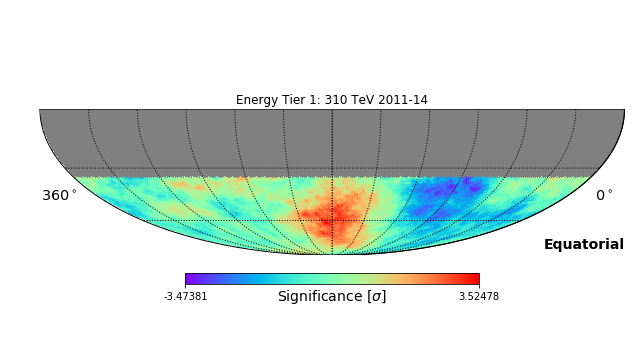

In [5]:
#SIGNIFICANCE

#FRANKS METHOD
data_smooth = smoothMap(data, smooth_rad=radius_smooth)
bg_smooth = smoothMap(bg, smooth_rad=radius_smooth)

with np.errstate(invalid='ignore', divide='ignore'):
    alpha = 1/20.
    #alpha = 1.
    # Allow for scaling term if weighted square maps necessary
    scale = 1.
    Non  = data_smooth * scale
    Noff = bg_smooth/alpha * scale

    sn = np.sign(data_smooth - bg_smooth)
    sigma = sn * sqrt(2*(Non*np.log(((1+alpha)*Non) / (alpha*(Non+Noff)))
                         + Noff * np.log(((1+alpha)*Noff) / (Non+Noff))))

sigma[np.isnan(sigma)] = 0
signed_significance = maskMap(sigma, decMin, decMax)
plot_map(signed_significance, Title, label='Significance [$\sigma$]', half_map=True) #, dMin=-3.5, dMax=3.5)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


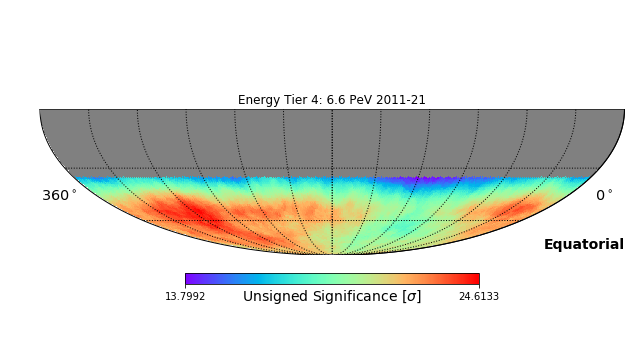

/cvmfs/icecube.opensciencegrid.org/py3-v4.1.1/Ubuntu_20.04_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


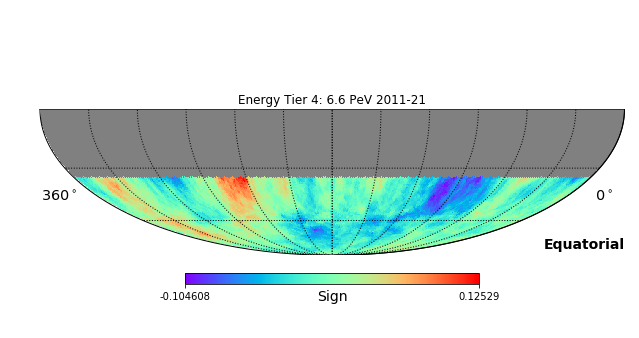

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


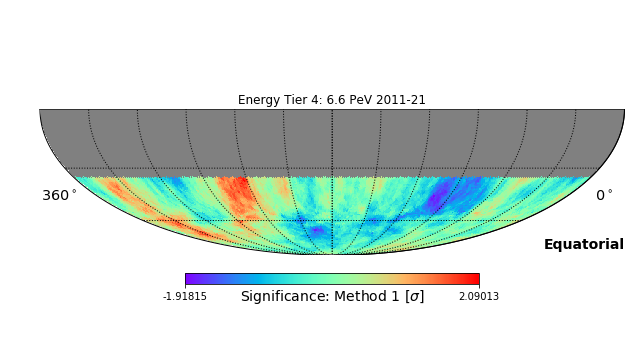

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


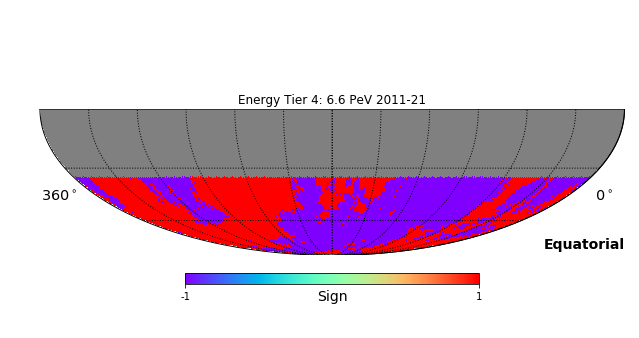

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


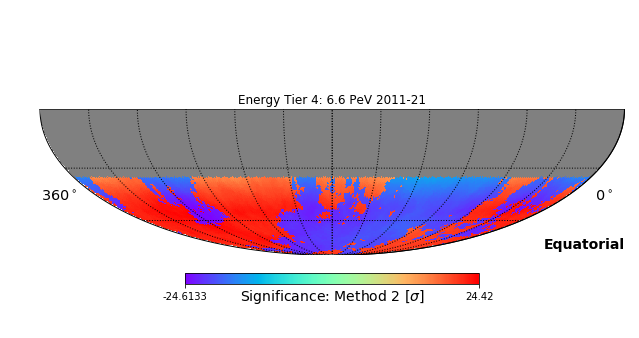

In [16]:
# SIGNIFICANCE SKYMAPS - JUAN CARLOS (MASK THEN SMOOTH) METHOD

# Unsigned significance
masked_variance = maskMap(sig, decMin, decMax)
variance_smooth = TopHatSmooth(nside, masked_variance, radius=radius_smooth, average=False) #Why is average false?
masked_np_variance_smooth = hp.ma(variance_smooth)
unsigned_significance = np.sqrt(np.abs(masked_np_variance_smooth))
plot_map(unsigned_significance, Title, label='Unsigned Significance [$\sigma$]', half_map=True)

# Calculating sign
rel_int = data/bg - 1
masked_combined = maskMap(rel_int, decMin, decMax)
num = TopHatSmooth(nside,masked_combined,radius=radius_smooth,average=True)


# Method used up till now:
abs_rel_int = np.abs(rel_int)
masked_denom = maskMap(abs_rel_int, decMin, decMax)
denom = TopHatSmooth(nside,masked_denom,radius=radius_smooth,average=True)
masked_np_num = hp.ma(num)
masked_np_denom = hp.ma(denom)
neg = masked_np_num / masked_np_denom
plot_map(neg, Title, label='Sign', half_map=True)

plot_map((unsigned_significance * neg).filled(fill_value=hp.UNSEEN), Title,
         label='Significance: Method 1 [$\sigma$]', half_map=True)

# Method where signs equals 1 (new attempt)
denom = np.abs(hp.ma(num))

masked_np_num = hp.ma(num)
masked_np_denom = hp.ma(denom)
neg_normalized = masked_np_num / masked_np_denom
plot_map(neg_normalized, Title, label='Sign', half_map=True)


plot_map((unsigned_significance * neg_normalized).filled(fill_value=hp.UNSEEN), Title, 
         label='Significance: Method 2 [$\sigma$]', half_map=True)


/cvmfs/icecube.opensciencegrid.org/py3-v4.1.1/Ubuntu_20.04_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


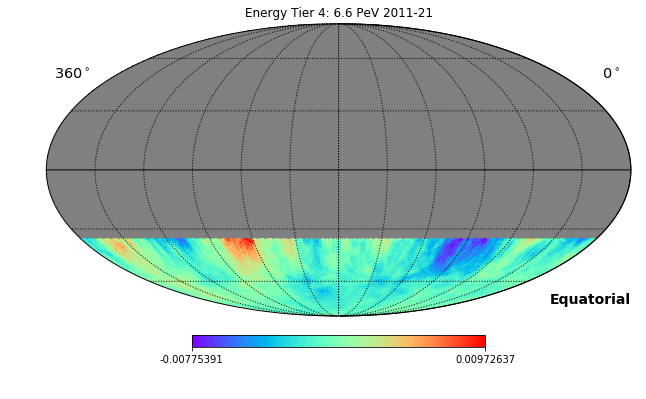

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


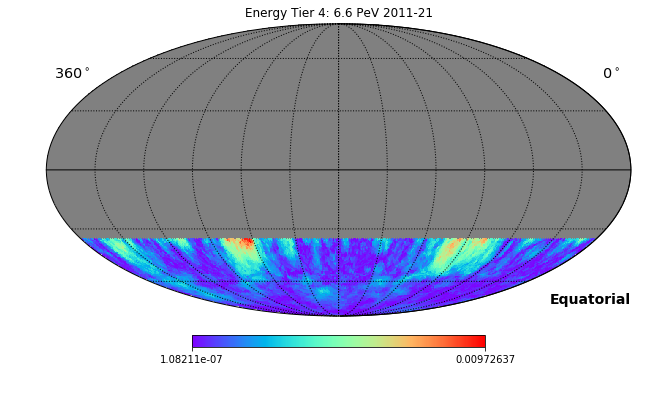

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


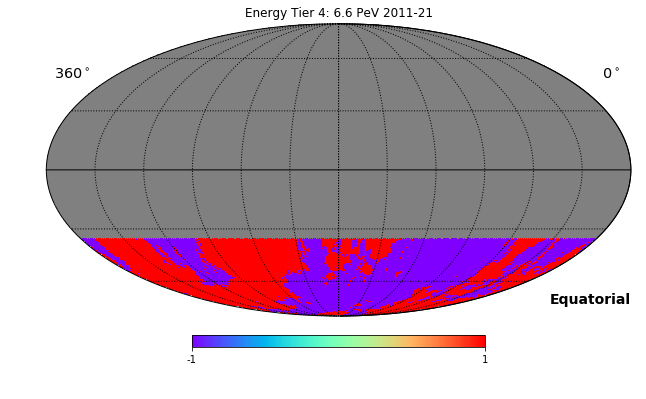

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


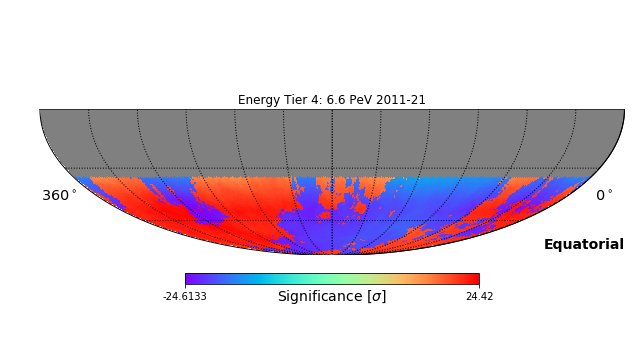

In [18]:
#JUAN CARLOS
#Significance- mask then smooth
rel_int = data/bg - 1
masked_combined = maskMap(rel_int, decMin, decMax)
masked_variance = maskMap(sig, decMin, decMax)

#Do np.abs on masked array to avoid taking the absolute value of hp.UNSEEN/dividing out hp.UNSEEN
num = TopHatSmooth(nside,masked_combined,radius=radius_smooth,average=True)
plot_map(num, Title)

"""
abs_rel_int = np.abs(rel_int)
masked_denom = maskMap(abs_rel_int, decMin, decMax)
plot_map(masked_denom, Title)
denom = TopHatSmooth(nside,masked_denom,radius=radius_smooth,average=True)
plot_map(denom, Title)
"""
denom = np.abs(hp.ma(num))
plot_map(denom.filled(fill_value=hp.UNSEEN), Title)

masked_np_num = hp.ma(num)
masked_np_denom = hp.ma(denom)
neg = masked_np_num / masked_np_denom
plot_map(neg, Title)

variance_smooth = TopHatSmooth(nside, masked_variance, radius=radius_smooth, average=False) 
masked_np_variance_smooth = hp.ma(variance_smooth)
significance_llh_iter20 = np.sqrt(np.abs(masked_np_variance_smooth))

#this makes sure that the significance has the right value and sign
signed_significance = significance_llh_iter20 * neg
signed_significance.filled(fill_value=hp.UNSEEN)
plot_map(signed_significance, Title, 
         label='Significance [$\sigma$]', half_map=True)

In [18]:
def smoothMap(m, wtsqr=False, norm=False, smooth_rad=0):

    if wtsqr==True:
        return None

    npix  = len(m)
    nside = hp.npix2nside(npix)
    #smooth_rad = opts['smooth'] * pi/180.
    smooth_map = np.zeros(npix)

    vec = np.transpose(hp.pix2vec(nside, np.arange(npix)))
    for i in range(npix):
        neighbors = hp.query_disc(nside, vec[i], smooth_rad)
        smooth_map[i] += m[neighbors].sum()
        if norm:
            smooth_map[i] /= (len(neighbors) + 1)

    return smooth_map

/cvmfs/icecube.opensciencegrid.org/py3-v4.1.1/Ubuntu_20.04_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


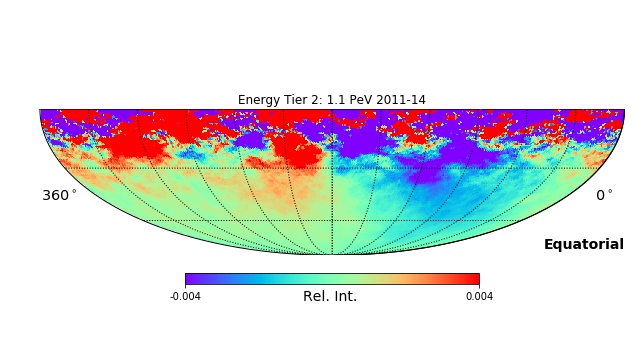

In [22]:
#FRANKS METHOD
data_smooth = smoothMap(data, smooth_rad=radius_smooth)
bg_smooth = smoothMap(bg, smooth_rad=radius_smooth)
m = (data_smooth - bg_smooth) / bg_smooth
m[np.isnan(m)] = 0
m = maskMap(m, decMin, decMax)

plot_map(m, Title, label="Rel. Int. ", half_map=True, dMin = -.004, dMax = .004)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


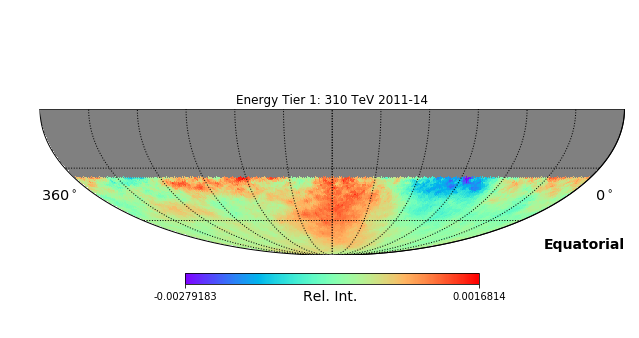

In [8]:
#My version of frank's version (gets same output)

data_smooth = TopHatSmooth(nside, data, radius_smooth, average=True)
bg_smooth = TopHatSmooth(nside, bg, radius_smooth, average=True)
ri = data_smooth - bg_smooth
ri_mask = maskMap(ri, decMin, decMax)
bg_mask = maskMap(bg_smooth, decMin, decMax)
masked_ri_a = hp.ma(ri_mask)
masked_bg_a = hp.ma(bg_mask)
ri_p = masked_ri_a / masked_bg_a
ri_p.filled(fill_value=hp.UNSEEN)

plot_map(ri_p, Title, label='Rel. Int. ', half_map = True) #, dMin = -.003, dMax = .003,         filename="/home/gagrawal/skymaps/output/ts_meth/et4_ri.png")

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


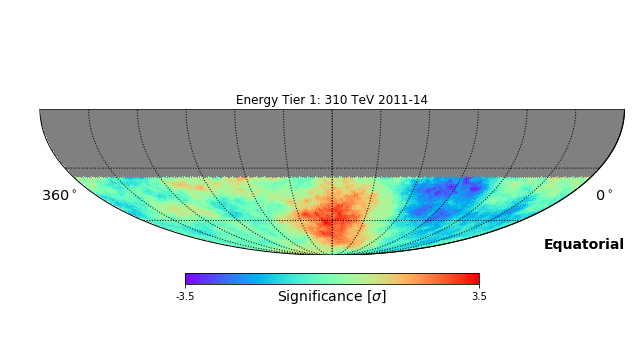

In [14]:
#SIGNIFICANCE

#FRANKS METHOD
data_smooth = smoothMap(data, smooth_rad=radius_smooth)
bg_smooth = smoothMap(bg, smooth_rad=radius_smooth)

with np.errstate(invalid='ignore', divide='ignore'):
    #alpha = 1/20.
    alpha = 1.
    # Allow for scaling term if weighted square maps necessary
    scale = 1.
    Non  = data_smooth * scale
    Noff = bg_smooth/alpha * scale

    sn = np.sign(data_smooth - bg_smooth)
    sigma = sn * sqrt(2*(Non*np.log(((1+alpha)*Non) / (alpha*(Non+Noff)))
                         + Noff * np.log(((1+alpha)*Noff) / (Non+Noff))))

sigma[np.isnan(sigma)] = 0
sigma_masked = maskMap(sigma, decMin, decMax)
plot_map(sigma_masked, Title, label='Significance [$\sigma$]', half_map=True, dMin=-3.5, dMax=3.5)

In [ ]:
#FRANKS CODE

In [ ]:
#Relative Intensity

#Mask then smooth
masked_map = maskMap(combined_llh_iter01, decMin, decMax)
smoothed_map = TopHatSmooth(nside, masked_map, radius_smooth, average=True)


plot_map(masked_map, Title, label='Rel. Int. Raw', half_map = True, dMin = -.05, dMax = .05)
plot_map(smoothed_map, Title, label='Rel. Int. ', half_map = True) 

In [ ]:
#FEB 2024 CODE

In [ ]:
#Relative Intensity

#Mask then smooth
masked_map = maskMap(combined_llh_iter20, decMin, decMax)
smoothed_map = TopHatSmooth(nside, masked_map, radius_smooth, average=True)
plot_map(smoothed_map, Title, label='Rel. Int. ', half_map = True) 

In [ ]:
#Plot with specificed range and save
plot_map(smoothed_map, Title, label='Rel. Int. ', half_map = True, dMin = -.012, dMax = .012, filename="/home/gagrawal/skymaps/output/et2_ri.png")

In [ ]:
#Significance- mask then smooth

masked_combined = maskMap(combined_llh_iter20, decMin, decMax)
masked_variance = maskMap(variance_llh_iter20, decMin, decMax)


#Do np.abs on masked array to avoid taking the absolute value of hp.UNSEEN/dividing out hp.UNSEEN
num = TopHatSmooth(nside,masked_combined,radius=radius_smooth,average=True)

masked_np_combined = hp.ma(masked_combined)
denom = TopHatSmooth(nside,np.abs(masked_np_combined).filled(fill_value=hp.UNSEEN),radius=radius_smooth,average=True)

masked_np_num = hp.ma(num)
masked_np_denom = hp.ma(denom)
neg = masked_np_num / masked_np_denom

variance_smooth = TopHatSmooth(nside, masked_variance, radius=radius_smooth, average=False) #Why is average false?
masked_np_variance_smooth = hp.ma(variance_smooth)
significance_llh_iter20 = np.sqrt(np.abs(masked_np_variance_smooth))

#this makes sure that the significance has the right value and sign
signed_significance = significance_llh_iter20 * neg

plot_map(signed_significance.filled(fill_value=hp.UNSEEN), Title, 
         label='Significance [$\sigma$]', half_map=True) 

In [ ]:
#Plot with specified range and save to directory
plot_map(signed_significance.filled(fill_value=hp.UNSEEN), Title, 
         label='Significance [$\sigma$]', half_map=True, dMin=-6, dMax=6, filename="/home/gagrawal/skymaps/output/et2_sig.png")

In [ ]:
#Relative Intensity - OG

#Smooth then mask
smoothed_map = TopHatSmooth(64,combined_llh_iter20,radius_smooth,average=True)

plot_map(smoothed_map, Title, label='Rel. Int. [$\sigma$]') #,dMin=-0.003, dMax=0.003)

masked_map = maskMap(smoothed_map, decMin, decMax)

plot_map(masked_map, Title, label='Rel. Int. [$\sigma$]', half_map = True) #,dMin=-0.003, dMax=0.003)

In [21]:
#Significance Skymap Calculation - OG

neg = TopHatSmooth(64,combined_llh_iter20,radius=smoothAngle*degree,average=True)/TopHatSmooth(64,np.abs(combined_llh_iter20),radius=5.0*degree,average=True)

#used to find the value of the significance, the maskMap 
variance_llh_smooth_iter20 = TopHatSmooth(64,variance_llh_iter20,radius=smoothAngle*degree, average=False)
significance_llh_iter20 = np.sqrt(np.abs(variance_llh_smooth_iter20))

#this makes sure that the significance has the right value and sign
signed_significance = significance_llh_iter20 * neg
masked_map = maskMap(signed_significance, decMin, decMax)

plot_map(masked_map, Title, label='Significance [$\sigma$]', half_map = True) #, dMin=-8, dMax=8)

KeyboardInterrupt: 